<a href="https://colab.research.google.com/github/aniuta-mul/SQL-projects/blob/main/Online_store_sales_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery pandas pyarrow

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

client = bigquery.Client()

In [ ]:
query = """
SELECT date,
       ord.ga_session_id AS session_id,
       continent,
       country,
       device,
       browser,
       mobile_model_name,
       operating_system,
       language,
       sp.medium AS traffic_source,
       channel,
       ac.id AS id_account,
       is_verified,
       is_unsubscribed,
       category,
       pr.name AS product_name,
       pr.price AS price,
       short_description
FROM `DA.order` ord
JOIN `DA.session` ss
ON ss.ga_session_id = ord.ga_session_id
JOIN `DA.session_params` sp
ON sp.ga_session_id = ss.ga_session_id
LEFT JOIN `DA.product` pr
ON ord.item_id = pr.item_id
LEFT JOIN `DA.account_session` ass
ON ord.ga_session_id = ass.ga_session_id
LEFT JOIN `DA.account` ac
ON ass.account_id = ac.id
"""

client = bigquery.Client(project="data-analytics-mate")
df = client.query(query).to_dataframe()
df.head()

,date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,channel,id_account,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-12-24,5726438444,(not set),(not set),desktop,Chrome,Chrome,Web,None,referral,Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,organic,Organic Search,<NA>,<NA>,<NA>,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33538 entries, 0 to 33537
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               33538 non-null  dbdate 
 1   session_id         33538 non-null  Int64  
 2   continent          33538 non-null  object 
 3   country            33538 non-null  object 
 4   device             33538 non-null  object 
 5   browser            33538 non-null  object 
 6   mobile_model_name  33538 non-null  object 
 7   operating_system   33538 non-null  object 
 8   language           22531 non-null  object 
 9   traffic_source     33538 non-null  object 
 10  channel            33538 non-null  object 
 11  id_account         2781 non-null   Int64  
 12  is_verified        2781 non-null   Int64  
 13  is_unsubscribed    2781 non-null   Int64  
 14  category           33538 non-null  object 
 15  product_name       33538 non-null  object 
 16  price              335

In [ ]:
df.describe()

,session_id,id_account,is_verified,is_unsubscribed,price
count,33538.0,2781.0,2781.0,2781.0,33538.000000
mean,4964900683.146312,658815.525351,0.71521,0.160734,953.298679
std,2884281407.544152,13140.190977,0.451395,0.367351,1317.001775
min,330355.0,636138.0,0.0,0.0,3.000000
25%,2476893918.0,647432.0,0.0,0.0,170.000000
50%,4961245290.0,658322.0,1.0,0.0,445.000000
75%,7442296865.75,670218.0,1.0,0.0,1195.000000
max,9999754183.0,681955.0,1.0,1.0,9585.000000


In [ ]:
df["date"].min()

datetime.date(2020, 11, 1)

In [ ]:
df["date"].max()

datetime.date(2021, 1, 27)

У датасеті 18 колонок, з яких 5 колонок числового типу: session_id, id_acount, is_verified, is_unsubscribed, price. 12 колонок категоріального типу: continent, country, devise, browser, mobile_model_name, operating_system, language,traffic_source, channel, category, product_name, short_description. Одна колонка типу datetime - date.

Розглядається період часу з 01.11.2020 по 27.01.2021. 33538 унікальних сесій, є пропущені значення у колонках language, id_acount, is_verified, is_unsubscribed. У колонці language є пропущені значення, бо у основній таблиці вони були відсутні. А у колонках id_acount, is_verified, is_unsubscribed відсутність значень пояснюється тим, що заповнена інформація лише про зареєстровані акаунти, а покупки здійснювалися також і через незареєстровані акаунти.


###Топ-3 континенти за продажами:

In [ ]:
revenue_top3_continent = df.groupby("continent")["price"].sum().reset_index().sort_values(by="price", ascending=False)[:3]
revenue_top3_continent

,continent,price
2,Americas,17665280.0
3,Asia,7601298.3
4,Europe,5934624.2


###Топ-5 країн за продажами:

In [ ]:
revenue_top5_country = df.groupby("country")["price"].sum().reset_index().sort_values(by="price", ascending=False)[:5]
revenue_top5_country

,country,price
104,United States,13943553.9
43,India,2809762.0
18,Canada,2437921.0
103,United Kingdom,938317.9
33,France,710692.8


###Топ-3 континенти за кількістю проданих одиниць товару:

In [ ]:
number_of_orders_top3_continent = df.groupby("continent")["session_id"].count().reset_index().sort_values(by="session_id", ascending=False)[:3]
number_of_orders_top3_continent

,continent,session_id
2,Americas,18553
3,Asia,7950
4,Europe,6261


###Топ-5 країн за кількістю проданих одиниць товару:

In [ ]:
number_of_orders_top5_country = df.groupby("country")["session_id"].count().reset_index().sort_values(by="session_id", ascending=False)[:5]
number_of_orders_top5_country

,country,session_id
104,United States,14673
43,India,3029
18,Canada,2560
103,United Kingdom,1029
33,France,678


###Візуалізація даних:

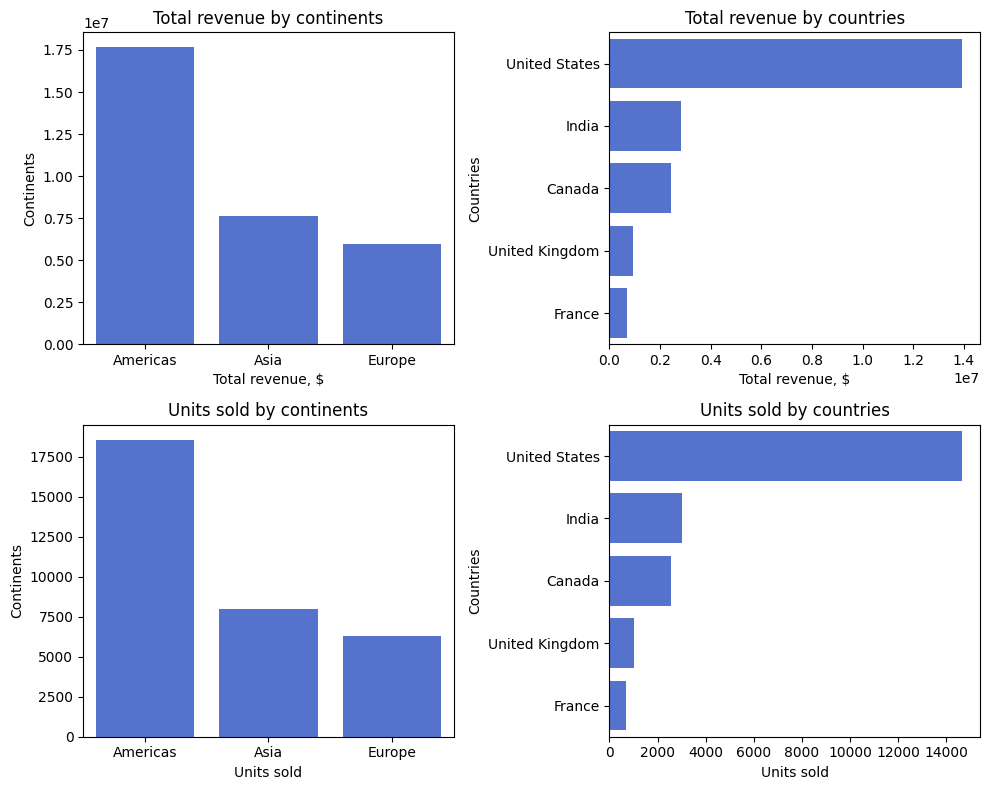

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

sns.barplot(data=revenue_top3_continent, y="price", x="continent", color="royalblue", errorbar=("ci", False), ax=ax[0, 0])
ax[0, 0].set_title("Total revenue by continents")
ax[0, 0].set_xlabel("Total revenue, $")
ax[0, 0].set_ylabel("Continents")

sns.barplot(data=revenue_top5_country, x="price", y="country", color="royalblue", errorbar=("ci", False), ax=ax[0, 1])
ax[0, 1].set_title("Total revenue by countries")
ax[0, 1].set_xlabel("Total revenue, $")
ax[0, 1].set_ylabel("Countries")

sns.barplot(data=number_of_orders_top3_continent, y="session_id", x="continent", color="royalblue", errorbar=("ci", False), ax=ax[1, 0])
ax[1, 0].set_title("Units sold by continents")
ax[1, 0].set_xlabel("Units sold")
ax[1, 0].set_ylabel("Continents")

sns.barplot(data=number_of_orders_top5_country, x="session_id", y="country", color="royalblue", errorbar=("ci", False), ax=ax[1, 1])
ax[1, 1].set_title("Units sold by countries")
ax[1, 1].set_xlabel("Units sold")
ax[1, 1].set_ylabel("Countries")

plt.tight_layout()
plt.show()

У розрізі континентів найбільше доходів і проданих одиниць у Америці, Азії і Європі. Також найбільше доходів і проданих одиниць у таких країнах як США, Індія, Канада, Велика Британія та Франція.

###Топ-10 категорій товарів за загальною сумою продажів:

In [ ]:
revenue_top10_category = df.groupby("category")["price"].sum().reset_index().sort_values(by="price", ascending=False)[:10]
revenue_top10_category

,category,price
12,Sofas & armchairs,8388254.5
5,Chairs,6147748.8
1,Beds,4919725.0
2,Bookcases & shelving units,3640818.1
3,Cabinets & cupboards,2336499.5
9,Outdoor furniture,2142222.2
13,Tables & desks,1790307.5
6,Chests of drawers & drawer units,906562.5
0,Bar furniture,735503.0
7,Children's furniture,467697.0


###Топ-10 категорій товарів у США (у країні з найбільшими продажами) за загальною сумою продажів:

In [ ]:
revenue_top10_by_category_united_states = df[df["country"].str.contains("United States")].groupby("category")["price"].sum().reset_index().sort_values(by="price", ascending=False)[:10]
revenue_top10_by_category_united_states

,category,price
12,Sofas & armchairs,3707144.5
5,Chairs,2619773.8
1,Beds,2213058.0
2,Bookcases & shelving units,1567606.9
3,Cabinets & cupboards,994545.5
9,Outdoor furniture,929245.2
13,Tables & desks,777865.0
6,Chests of drawers & drawer units,382388.0
0,Bar furniture,330805.0
7,Children's furniture,207575.0


###Топ-10 категорій товарів у розрізі Америки (на континенті з найбільшими продажами) за загальною сумою продажів:

In [ ]:
revenue_top10_by_category_americas = df[df["continent"].str.contains("Americas")].groupby("category")["price"].sum().reset_index().sort_values(by="price", ascending=False)[:10]
revenue_top10_by_category_americas

,category,price
12,Sofas & armchairs,4737307.0
5,Chairs,3309203.0
1,Beds,2773094.0
2,Bookcases & shelving units,1968919.3
3,Cabinets & cupboards,1275562.5
9,Outdoor furniture,1213115.2
13,Tables & desks,968129.0
6,Chests of drawers & drawer units,484290.0
0,Bar furniture,406198.0
7,Children's furniture,253435.0


###Візуалізація даних:

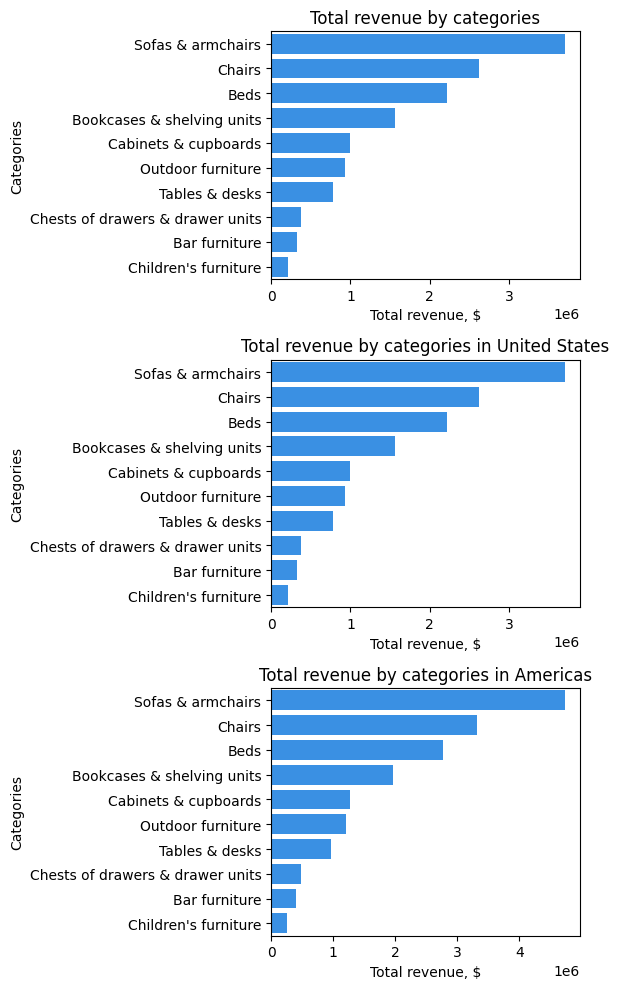

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

sns.barplot(data=revenue_top10_by_category_united_states, x="price", y="category", color="dodgerblue", errorbar=("ci", False), ax=ax[0])
ax[0].set_title("Total revenue by categories")
ax[0].set_xlabel("Total revenue, $")
ax[0].set_ylabel("Categories")

sns.barplot(data=revenue_top10_by_category_united_states, x="price", y="category", color="dodgerblue", errorbar=("ci", False), ax=ax[1])
ax[1].set_title("Total revenue by categories in United States")
ax[1].set_xlabel("Total revenue, $")
ax[1].set_ylabel("Categories")


sns.barplot(data=revenue_top10_by_category_americas, x="price", y="category", color="dodgerblue", errorbar=("ci", False), ax=ax[2])
ax[2].set_title("Total revenue by categories in Americas")
ax[2].set_xlabel("Total revenue, $")
ax[2].set_ylabel("Categories")

plt.tight_layout()
plt.show()

Найбільше доходу приносять такі категорії товарів як Sofas & armchairs, Chairs, Beds, Bookcases & shelving units, Cabinets & cupboards, Outdoor furniture, Tables & desks, Chests of drawers & drawer units, Bar furniture, Children's furniture. Така ж тенденція зберігається у країні США, де найбільші продажі та на континенті Америка з найбільшими продажами.

###Топ-10 категорій товарів за кількістю проданих одиниць:

In [ ]:
units_sold_top10_category = df.groupby("category")["session_id"].count().reset_index().sort_values(by="session_id", ascending=False)[:10]
units_sold_top10_category

,category,session_id
2,Bookcases & shelving units,7630
5,Chairs,5952
12,Sofas & armchairs,4301
13,Tables & desks,2941
1,Beds,2926
3,Cabinets & cupboards,2318
9,Outdoor furniture,2229
7,Children's furniture,1702
6,Chests of drawers & drawer units,1452
0,Bar furniture,1092


###Топ-10 категорій товарів у США (у країні з найбільшими продажами) за кількістю проданих одиниць:

In [ ]:
units_sold_top10_by_category_united_states = df[df["country"].str.contains("United States")].groupby("category")["session_id"].count().reset_index().sort_values(by="session_id", ascending=False)[:10]
units_sold_top10_by_category_united_states

,category,session_id
2,Bookcases & shelving units,3374
5,Chairs,2576
12,Sofas & armchairs,1903
1,Beds,1298
13,Tables & desks,1248
3,Cabinets & cupboards,995
9,Outdoor furniture,984
7,Children's furniture,752
6,Chests of drawers & drawer units,616
0,Bar furniture,487


###Топ-10 категорій товарів у розрізі Америки (на континенті з найбільшими продажами) за кількістю проданих одиниць:

In [ ]:
units_sold_top10_by_category_americas = df[df["continent"].str.contains("Americas")].groupby("category")["session_id"].count().reset_index().sort_values(by="session_id", ascending=False)[:10]
units_sold_top10_by_category_americas

,category,session_id
2,Bookcases & shelving units,4231
5,Chairs,3296
12,Sofas & armchairs,2403
1,Beds,1645
13,Tables & desks,1573
3,Cabinets & cupboards,1271
9,Outdoor furniture,1252
7,Children's furniture,944
6,Chests of drawers & drawer units,777
0,Bar furniture,606


###Візуалізація даних:

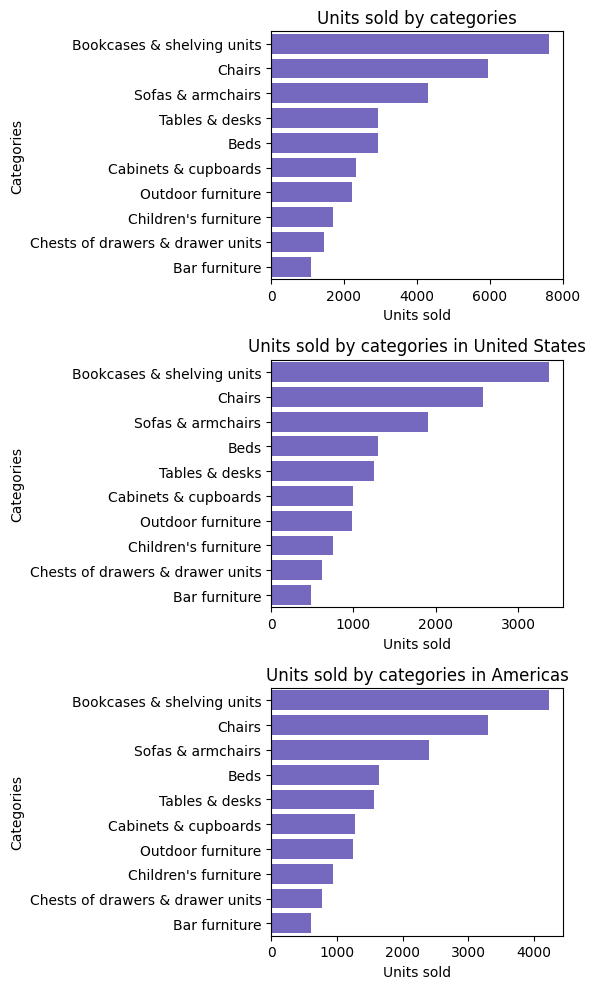

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

sns.barplot(data=units_sold_top10_category, x="session_id", y="category", color="slateblue", errorbar=("ci", False), ax=ax[0])
ax[0].set_title("Units sold by categories")
ax[0].set_xlabel("Units sold")
ax[0].set_ylabel("Categories")

sns.barplot(data=units_sold_top10_by_category_united_states, x="session_id", y="category", color="slateblue", errorbar=("ci", False), ax=ax[1])
ax[1].set_title("Units sold by categories in United States")
ax[1].set_xlabel("Units sold")
ax[1].set_ylabel("Categories")


sns.barplot(data=units_sold_top10_by_category_americas, x="session_id", y="category", color="slateblue", errorbar=("ci", False), ax=ax[2])
ax[2].set_title("Units sold by categories in Americas")
ax[2].set_xlabel("Units sold")
ax[2].set_ylabel("Categories")

plt.tight_layout()
plt.show()

Найбільша кількість проданих одиниць для таких категорії товарів як Bookcases & shelving units, Chairs, Sofas & armchairs, Beds, Tables & desks, Cabinets & cupboards, Outdoor furniture, Children's furniture, Chests of drawers & drawer units, Bar furniture. Така ж тенденція зберігається у країні США, де найбільші продажі та на континенті Америка з найбільшими продажами.

###Загальні продажі у розрізі типів девайсів:

In [ ]:
revenu_by_device = df.groupby("device")["price"].sum().reset_index()
revenu_by_device

,device,price
0,desktop,18864039.0
1,mobile,12384225.8
2,tablet,723466.3


###Загальні продажі у розрізі моделей девайсів:

In [ ]:
revenu_by_mobile_model_name = df.groupby("mobile_model_name")["price"].count().reset_index()
revenu_by_mobile_model_name

,mobile_model_name,price
0,<Other>,6801
1,Chrome,9359
2,ChromeBook,1877
3,Edge,741
4,Firefox,430
5,Pixel 3,105
6,Pixel 4 XL,117
7,Safari,6833
8,iPad,456
9,iPhone,6819


###Візуалізація даних:

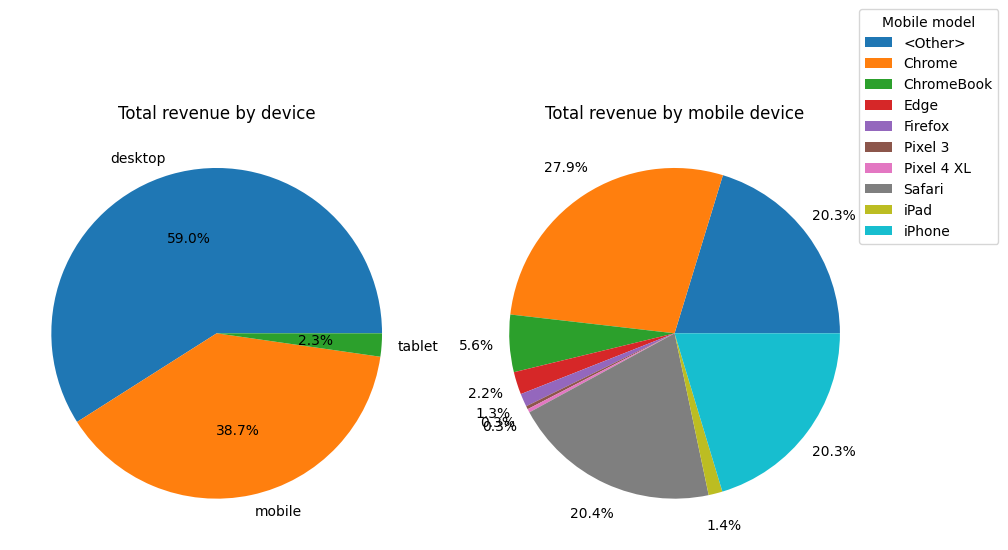

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

labels = [f"{reg}" for reg, reven in zip(revenu_by_device["device"], revenu_by_device["price"])]
ax[0].pie(revenu_by_device["price"], labels=labels, autopct="%1.1f%%")
ax[0].set_title("Total revenue by device")

ax[1].pie(revenu_by_mobile_model_name["price"], autopct="%1.1f%%", pctdistance=1.2)
ax[1].set_title("Total revenue by mobile device")

plt.legend(labels=revenu_by_mobile_model_name["mobile_model_name"], title="Mobile model", loc="right", bbox_to_anchor=(1, 0, 0.3, 2))
plt.tight_layout()
plt.show()

Найбільше доходів для компанії приносять замовлення зроблені на desktop, а у розрізі моделі девайсу - Chrome, Safari та iPhone.

###Загальні продажі за джерелами трафіку:

In [ ]:
revenu_by_channel = df.groupby("channel")["price"].count().reset_index()
revenu_by_channel

,channel,price
0,Direct,7800
1,Organic Search,11921
2,Paid Search,9042
3,Social Search,2716
4,Undefined,2059


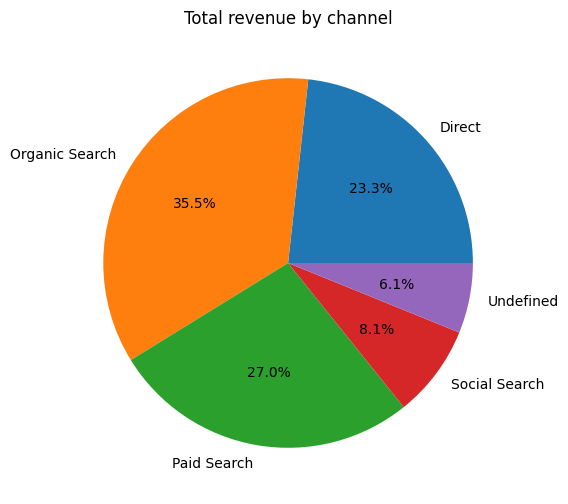

In [ ]:
plt.figure(figsize=(6, 6))

labels = [f"{reg}" for reg, reven in zip(revenu_by_channel["channel"], revenu_by_channel["price"])]
plt.pie(revenu_by_channel["price"], labels=labels, autopct="%1.1f%%")
plt.title("Total revenue by channel")

plt.show()

Найбільше продажів відбувається за джерелами трафіку Organic Search, Paid Search, Direct.



###Динаміка продажів у часі:

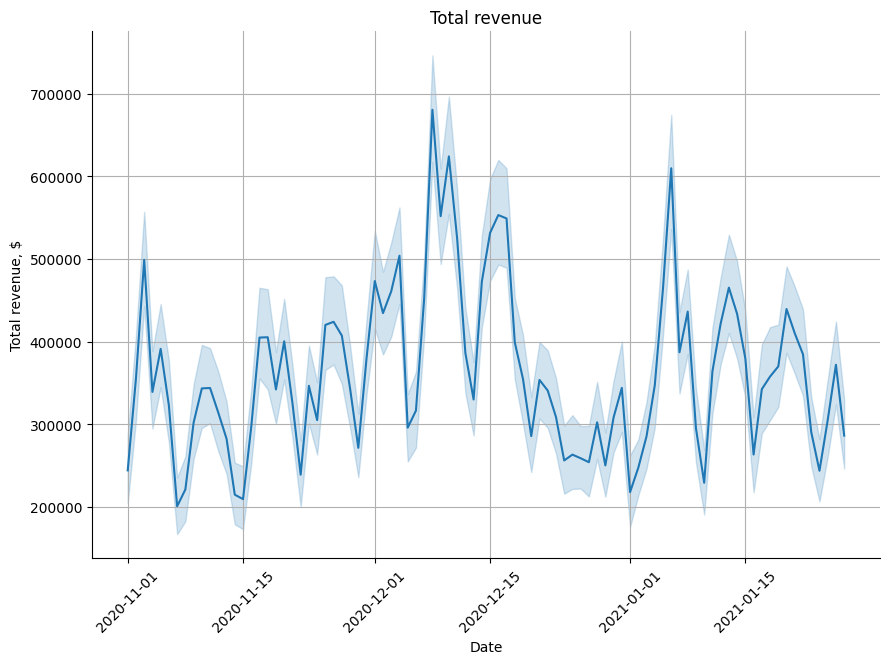

In [ ]:
sns.relplot(x="date", y="price", kind="line", data=df, estimator='sum', height=6, aspect=1.5, hue=None, style=None)
plt.xticks(rotation=45)
plt.title("Total revenue")
plt.xlabel("Date")
plt.ylabel("Total revenue, $")
plt.grid(True)
plt.show()

Наявність сезонних патернів, імовірно, тижневої сезонності, коли активність клієнтів зростає у певні дні тижня. Також помічено зростання продажів на початку грудня 2020 року і на початку січня 2021 року які, ймовірно, пов’язані з акціями чи розпродажами.

###Динаміка продажів у розрізі континентів:

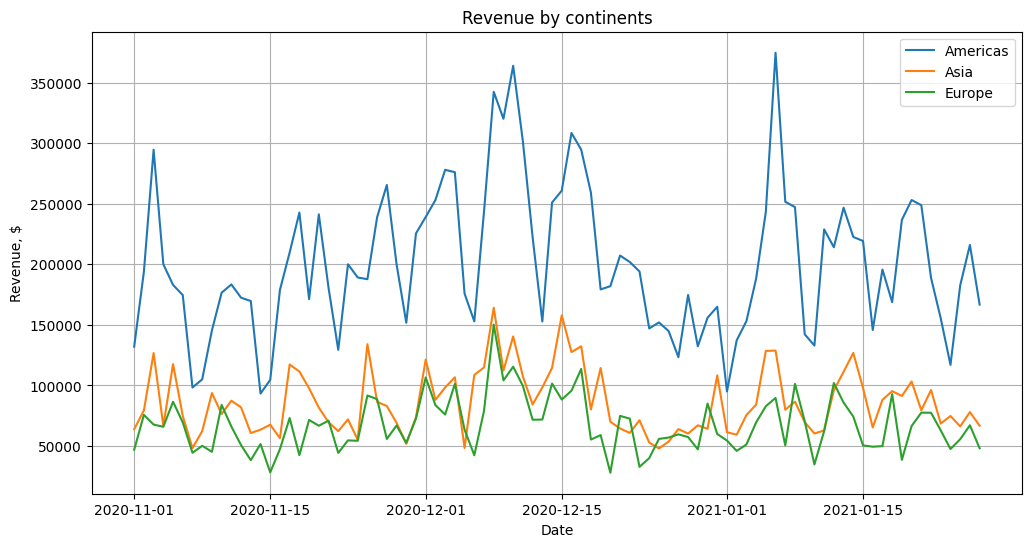

In [ ]:
df_by_continent = df[df["continent"].isin(["Americas", "Asia", "Europe"])]
revenue_by_continent = df_by_continent.groupby(["date", "continent"])["price"].sum().reset_index()
continents = revenue_by_continent["continent"].unique()

plt.figure(figsize=(12, 6))
for continent in continents:
    df_by_continent = revenue_by_continent[revenue_by_continent["continent"] == continent]
    plt.plot(df_by_continent["date"], df_by_continent["price"], label=continent)

plt.xlabel("Date")
plt.ylabel("Revenue, $")
plt.title("Revenue by continents")
plt.legend()
plt.grid(True)
plt.show()

Наявні сезонні патерни як і на попередньому графіку, для усіх континентів вони повторюються. Також помічено, що значна кількість копупок відбувається на континенті америка.

###Динаміка продажів у розрізі категорій товарів:

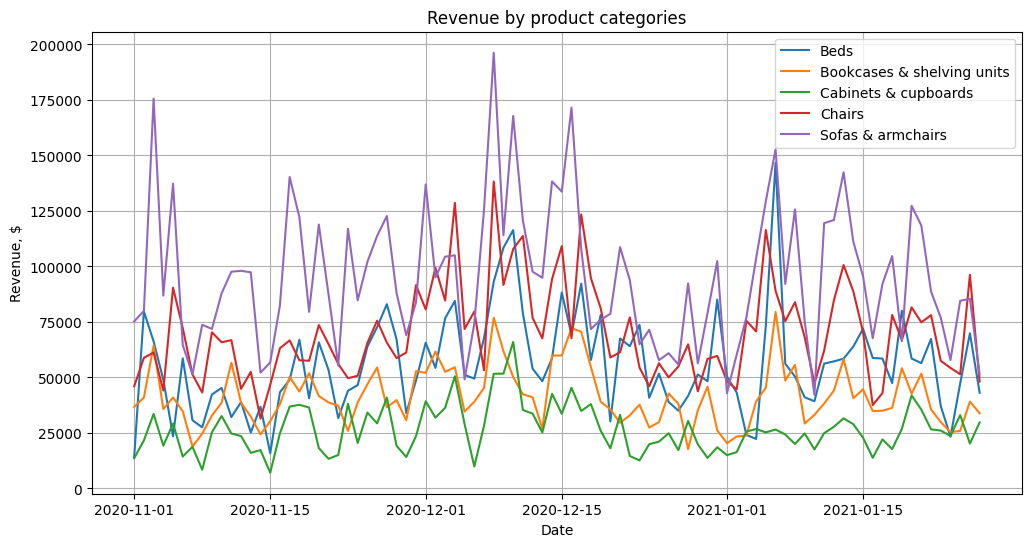

In [ ]:
df_by_5category = df[df["category"].isin(["Sofas & armchairs", "Chairs", "Beds", "Bookcases & shelving units", "Cabinets & cupboards"])]
revenue_by_category = df_by_5category.groupby(["date", "category"])["price"].sum().reset_index()
categories = revenue_by_category["category"].unique()

plt.figure(figsize=(12, 6))
for category in categories:
    df_by_5category = revenue_by_category[revenue_by_category["category"] == category]
    plt.plot(df_by_5category["date"], df_by_5category["price"], label=category)

plt.xlabel("Date")
plt.ylabel("Revenue, $")
plt.title("Revenue by product categories")
plt.legend()
plt.grid(True)
plt.show()

Наявні сезонні патерни як і на попередніх графіках, вони досить схожі для всіх категорій товарів.

###Динаміка продажів у розрізі джерел трафіку:

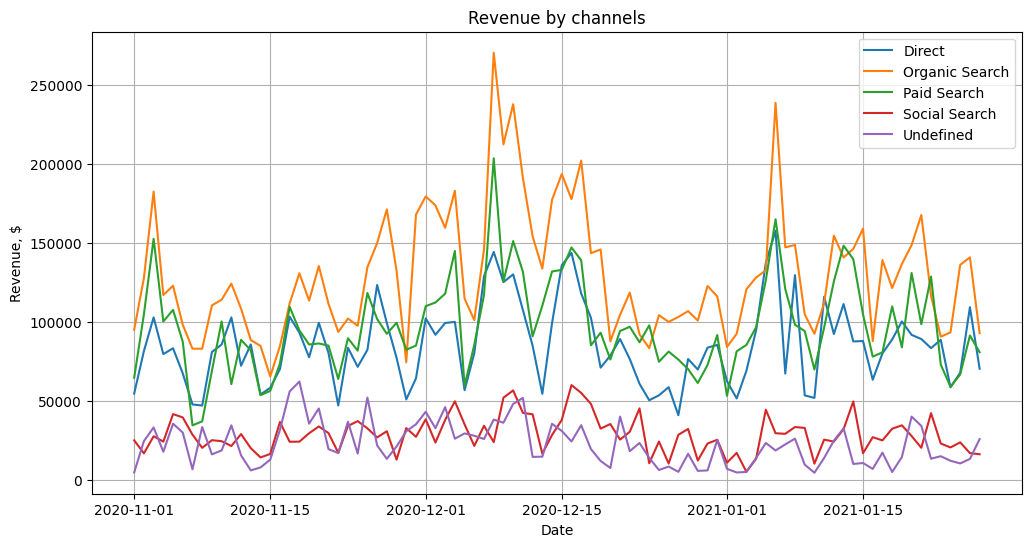

In [ ]:
revenue_by_channel = df.groupby(["date", "channel"])["price"].sum().reset_index()
channels = revenue_by_channel ["channel"].unique()

plt.figure(figsize=(12, 6))
for channel in channels:
    df = revenue_by_channel[revenue_by_channel["channel"] == channel]
    plt.plot(df["date"], df["price"], label=channel)

plt.xlabel("Date")
plt.ylabel("Revenue, $")
plt.title("Revenue by channels")
plt.legend()
plt.grid(True)
plt.show()

###Динаміка продажів у розрізі типів девайсів:

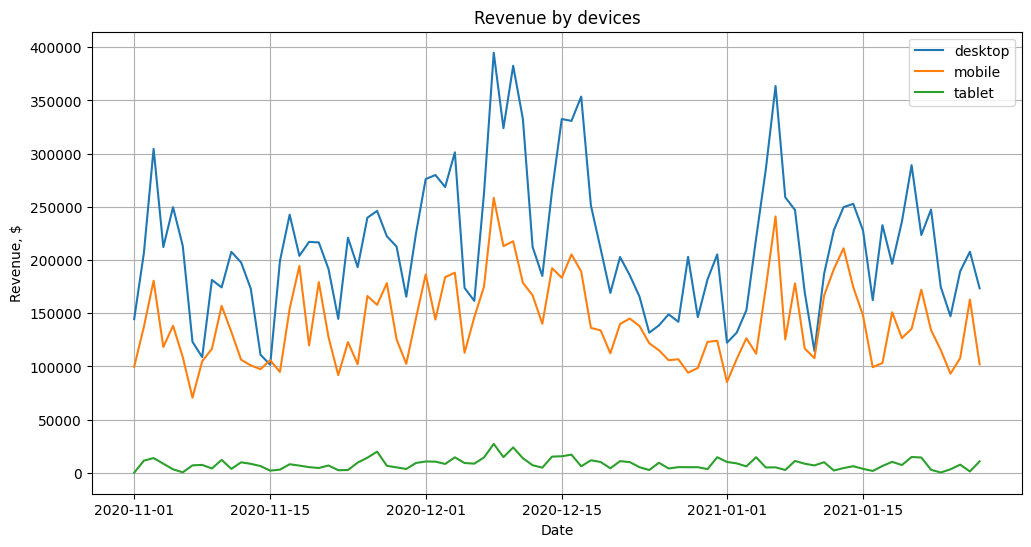

In [ ]:
revenue_by_device = df.groupby(["date", "device"])["price"].sum().reset_index()
devices = revenue_by_device ["device"].unique()

plt.figure(figsize=(12, 6))
for device in devices:
    df = revenue_by_device[revenue_by_device["device"] == device]
    plt.plot(df["date"], df["price"], label=device)

plt.xlabel("Date")
plt.ylabel("Revenue, $")
plt.title("Revenue by devices")
plt.legend()
plt.grid(True)
plt.show()

Значна чатина замовлень зроблена з desktop і mobile.

###Кількість сесій у розрізі каналів трафіку та типів девайсів:

In [ ]:
pivot_table_count_channel_device = pd.pivot_table(df, values="session_id", index="channel", columns="device", aggfunc="count").reset_index()
pivot_table_count_channel_device

device,channel,desktop,mobile,tablet
0,Direct,4655,2985,160
1,Organic Search,7011,4655,255
2,Paid Search,5261,3574,207
3,Social Search,1594,1065,57
4,Undefined,1181,834,44


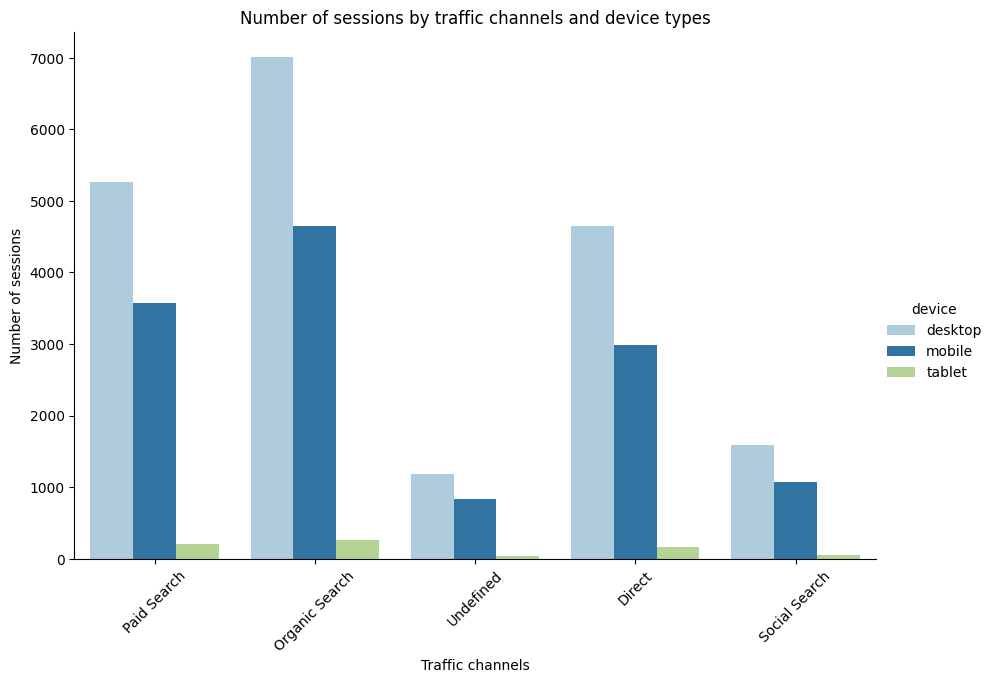

In [ ]:
sns.catplot(x="channel", kind="count", hue="device", data=df,
            errorbar=("ci", False), palette="Paired", height=6, aspect=1.5)
plt.xticks(rotation=45)
plt.title("Number of sessions by traffic channels and device types")
plt.xlabel("Traffic channels")
plt.ylabel("Number of sessions")
plt.show()

Найбільше сесій здійснено у Organic Search з desktop. А наймеше сесій здійснено з невідомих каналів трафіку з tablet.

In [ ]:
df_5country_10category = df[df["country"].isin(["United States", "India", "Canada", "United Kingdom", "France"]) &
                         df["category"].isin(["Sofas & armchairs", "Chairs", "Beds", "Bookcases & shelving units", "Cabinets & cupboards",
                                              "Cabinets & cupboards", "Outdoor furniture", "Tables & desks", "Chests of drawers & drawer units",
                                              "Bar furniture", "Children's furniture"])]
pivot_table_revenue_5country_10category = pd.pivot_table(df_5country_10category, values="price", index="category", columns="country", aggfunc="sum").reset_index()
pivot_table_revenue_5country_10category

country,category,Canada,France,India,United Kingdom,United States
0,Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
1,Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
2,Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
3,Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
4,Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
5,Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
6,Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
7,Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
8,Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5
9,Tables & desks,132678.0,42299.0,186157.5,49374.0,777865.0


###Загальні продажі товарів  за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн):


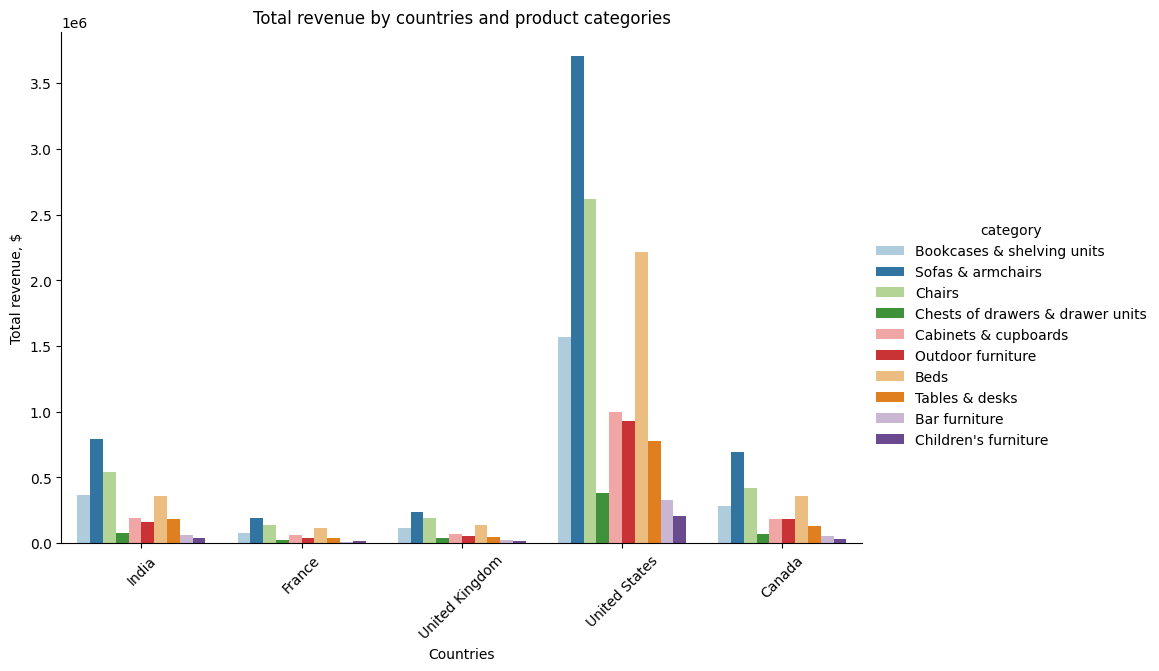

In [ ]:
sns.catplot(x="country", y="price", kind="bar", hue="category", data=df_5country_10category, estimator='sum',
            errorbar=("ci", False), palette="Paired", height=6, aspect=1.5)
plt.xticks(rotation=45)
plt.title("Total revenue by countries and product categories")
plt.xlabel("Countries")
plt.ylabel("Total revenue, $")
plt.show()

Як бачимо суттєвий дохід для компанії приносить США. А у розрізі категорій товарів, як для цієї країни як і для інших - категорія Sofas & armchairs.

###Загальні продажі товарів  за категоріями товарів (топ-10 категорій) на різних континентах:

In [ ]:
df_3continent_10category = df[df["continent"].isin(["Americas", "Asia", "Europe"]) &
                         df["category"].isin(["Sofas & armchairs", "Chairs", "Beds", "Bookcases & shelving units", "Cabinets & cupboards",
                                              "Cabinets & cupboards", "Outdoor furniture", "Tables & desks", "Chests of drawers & drawer units",
                                              "Bar furniture", "Children's furniture"])]
df_3continent_10category = pd.pivot_table(df_3continent_10category, values="price", index="category", columns="continent", aggfunc="sum").reset_index()
df_3continent_10category

continent,category,Americas,Asia,Europe
0,Bar furniture,406198.0,176684.0,131110.0
1,Beds,2773094.0,1077325.5,925047.5
2,Bookcases & shelving units,1968919.3,945368.9,650889.5
3,Cabinets & cupboards,1275562.5,545369.5,468652.5
4,Chairs,3309203.0,1524600.8,1178581.0
5,Chests of drawers & drawer units,484290.0,210383.5,186793.0
6,Children's furniture,253435.0,112389.0,93479.0
7,Outdoor furniture,1213115.2,488607.6,399553.2
8,Sofas & armchairs,4737307.0,1950022.0,1491224.5
9,Tables & desks,968129.0,464192.5,307045.0


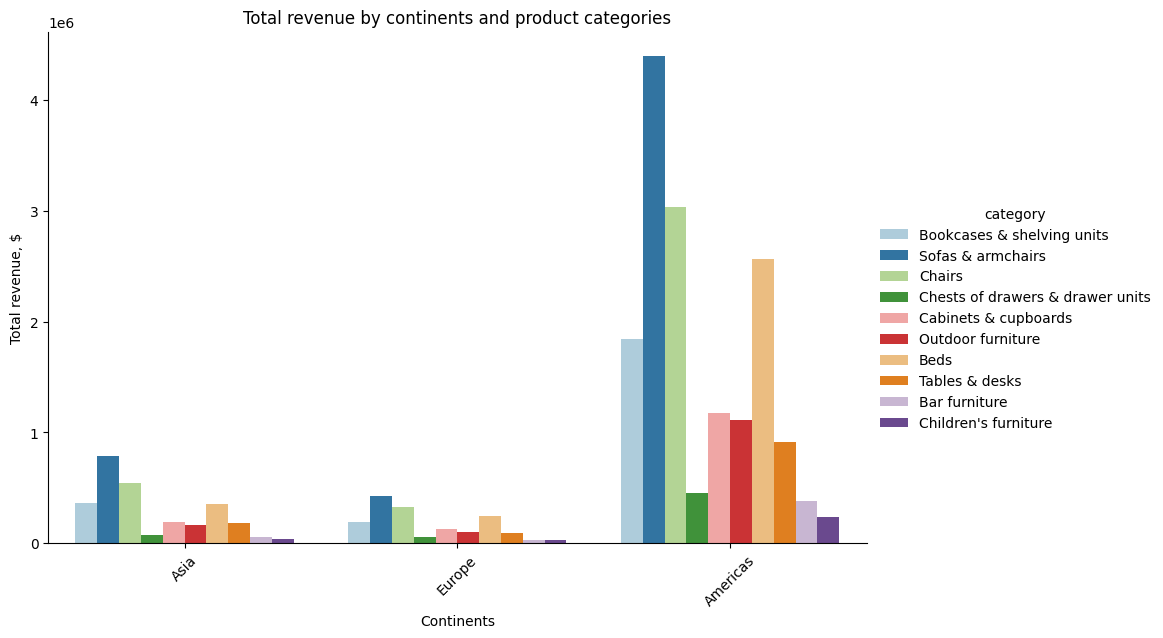

In [ ]:
sns.catplot(x="continent", y="price", kind="bar", hue="category", data=df_5country_10category, estimator='sum',
            errorbar=("ci", False), palette="Paired", height=6, aspect=1.5)
plt.xticks(rotation=45)
plt.title("Total revenue by continents and product categories")
plt.xlabel("Continents")
plt.ylabel("Total revenue, $")
plt.show()

Як бачимо найбільший дохід компанії приносить континент Америка. А у розрізі категорій товарів, на всіх континетах - категорія Sofas & armchairs.

In [ ]:
df_10category = df[df["category"].isin(["Sofas & armchairs", "Chairs", "Beds", "Bookcases & shelving units", "Cabinets & cupboards",
                                              "Cabinets & cupboards", "Outdoor furniture", "Tables & desks", "Chests of drawers & drawer units",
                                              "Bar furniture", "Children's furniture"])]
df_device_10category = pd.pivot_table(df_10category, values="price", index="category", columns="device", aggfunc="sum").reset_index()
df_device_10category

device,category,desktop,mobile,tablet
0,Bar furniture,432064.0,288279.0,15160.0
1,Beds,2865738.5,1958846.0,95140.5
2,Bookcases & shelving units,2129667.4,1437188.1,73962.6
3,Cabinets & cupboards,1381298.5,893916.0,61285.0
4,Chairs,3734573.0,2250582.4,162593.4
5,Chests of drawers & drawer units,537674.0,350845.5,18043.0
6,Children's furniture,283647.0,173813.0,10237.0
7,Outdoor furniture,1248420.6,846723.8,47077.8
8,Sofas & armchairs,4888456.5,3310256.0,189542.0
9,Tables & desks,1067212.5,682856.0,40239.0


###Загальні продажі товарів за категоріями товарів (топ-10 категорій) на різних типах девайсів:

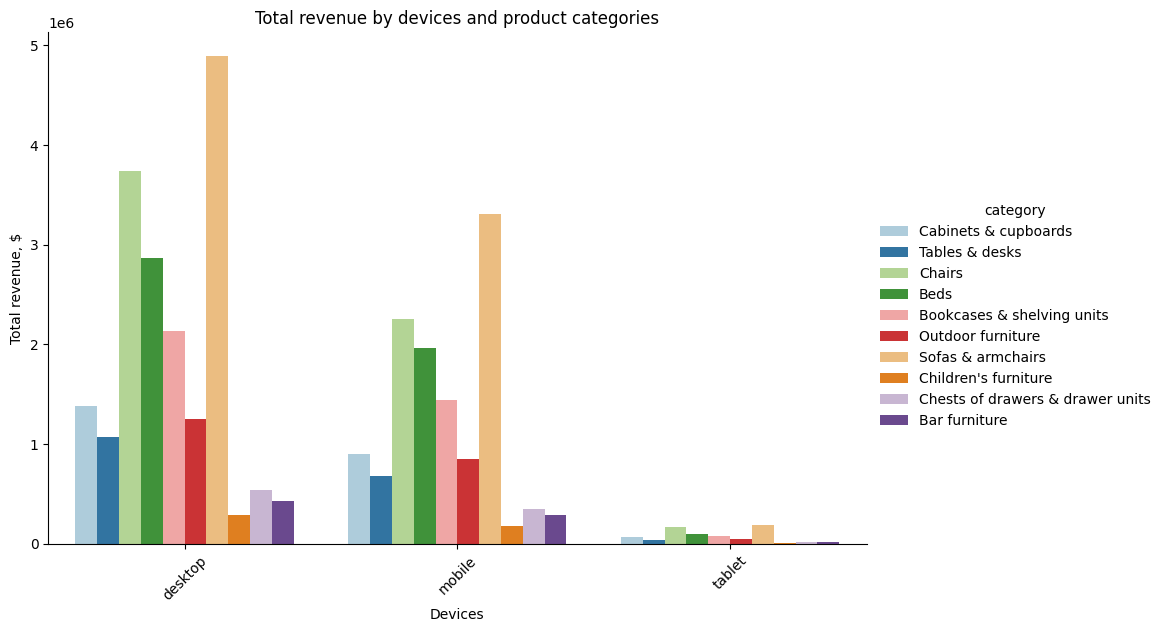

In [ ]:
sns.catplot(x="device", y="price", kind="bar", hue="category", data=df_10category, estimator='sum',
            errorbar=("ci", False), palette="Paired", height=6, aspect=1.5)
plt.xticks(rotation=45)
plt.title("Total revenue by devices and product categories")
plt.xlabel("Devices")
plt.ylabel("Total revenue, $")
plt.show()

Найбільше доходів для компанії приносять замовлення здійснені на desktop, а найменше - tablet.

###Кореляція продажів та кількості сесій:

In [ ]:
sales_by_date =  df.groupby("date")["price"].agg(["sum", "count"]).reset_index()
sales_by_date

,date,sum,count
0,2020-11-01,244292.5,281
1,2020-11-02,355506.8,368
2,2020-11-03,498979.6,561
3,2020-11-04,339187.1,370
4,2020-11-05,391276.6,388
...,...,...,...
83,2021-01-23,290605.5,313
84,2021-01-24,243818.4,296
85,2021-01-25,305089.3,370
86,2021-01-26,372057.3,385


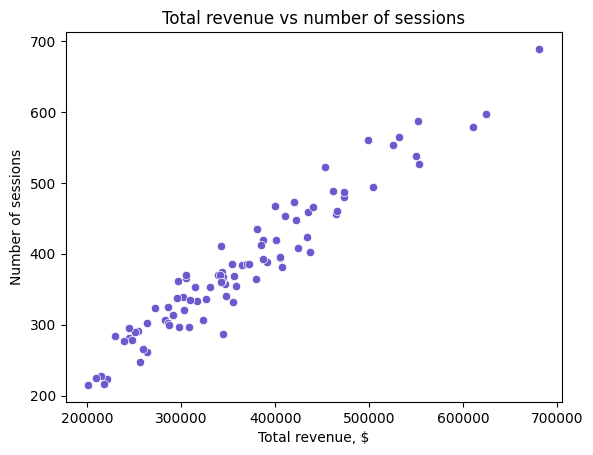

In [ ]:
sns.scatterplot(data=sales_by_date, x="sum", y="count", color="slateblue")
plt.title("Total revenue vs number of sessions")
plt.xlabel("Total revenue, $")
plt.ylabel("Number of sessions")
plt.show()

In [ ]:
from scipy.stats import pearsonr

print(f"Test statistic and p-value: {pearsonr(sales_by_date["sum"], sales_by_date["count"])}")

pearson_corr = sales_by_date["sum"].corr(sales_by_date["count"])
print(f"Pearson Correlation: {pearson_corr}")

Test statistic and p-value: PearsonRResult(statistic=0.9642422533124871, pvalue=2.2447783149167257e-51)
Pearson Correlation: 0.9642422533124876


Оскільки p-value < 0.05, взаємозв'язок між продажами і кількістю сесій є статистично значущим. За величиною коефіцієнта кореляції, приблизно 0.964, робимо висновок, що змінні мають сильний прямий зв'язок.

###Кореляція продажів на різних континентах:

In [ ]:
import scipy.stats as stats

sales_by_3continent = pd.pivot_table(df[df["continent"].isin(["Americas", "Asia", "Europe"])], values="price", index="date", columns="continent", aggfunc="sum")
continents = sales_by_3continent.columns

corr_matrix = pd.DataFrame(index=continents, columns=continents)
p_value_matrix = pd.DataFrame(index=continents, columns=continents)

for i in continents:
    for j in continents:
        if i != j:
            corr, p_value = stats.pearsonr(sales_by_3continent[i].dropna(), sales_by_3continent[j].dropna())
            corr_matrix.loc[i, j] = corr
            p_value_matrix.loc[i, j] = p_value
        else:
            corr_matrix.loc[i, j] = 1
            p_value_matrix.loc[i, j] = np.nan

print("Correlation matrix for the top 3 continents:")
print(corr_matrix)

print("\nP-value matrix for the top 3 continents:")
print(p_value_matrix)

Correlation matrix for the top 3 continents:
continent  Americas      Asia    Europe
continent                              
Americas          1  0.692273  0.669527
Asia       0.692273         1  0.667786
Europe     0.669527  0.667786         1

P-value matrix for the top 3 continents:
continent Americas Asia Europe
continent                     
Americas       NaN  0.0    0.0
Asia           0.0  NaN    0.0
Europe         0.0  0.0    NaN


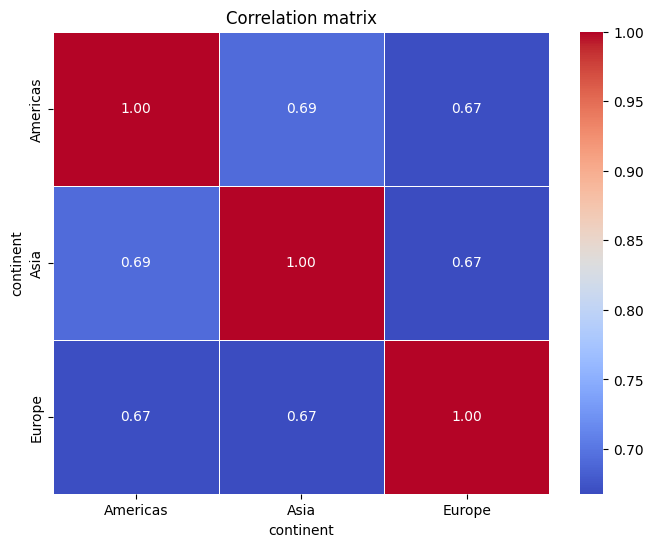

In [ ]:
corr_matrix = sales_by_3continent.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix for the top 3 continents")
plt.show()

Як бачимо звʼязок між продажами на різних котринентах є позитивний відносно тісний звʼязок, але він не є повністю визначений. Оскільки для всіх коефіцієнтів кореляцій є p-value < 0.05, взаємозв'язок між продажами на різних котринентах є статистично значущим, тобто існує мала ймовірність того, що такий рівень кореляції отриманий випадково.

###Кореляція продажів у різних країнах:

In [ ]:
sales_by_5country = pd.pivot_table(df[df["country"].isin(["United States", "India", "Canada", "United Kingdom", "France"])], values="price", index="date", columns="country", aggfunc="sum")
counties = sales_by_5country.columns

corr_matrix = pd.DataFrame(index=counties, columns=counties)
p_value_matrix = pd.DataFrame(index=counties, columns=counties)

for i in counties:
    for j in counties:
        if i != j:
            corr, p_value = stats.pearsonr(sales_by_5country[i].dropna(), sales_by_5country[j].dropna())
            corr_matrix.loc[i, j] = corr
            p_value_matrix.loc[i, j] = p_value
        else:
            corr_matrix.loc[i, j] = 1
            p_value_matrix.loc[i, j] = np.nan

print("Correlation matrix for top 3 countries:")
print(corr_matrix)

print("\nP-value matrix for top 3 countries:")
print(p_value_matrix)

Correlation matrix for top 3 countries:
country           Canada    France     India United Kingdom United States
country                                                                  
Canada                 1  0.312449  0.371538       0.238514       0.57452
France          0.312449         1  0.274374       0.172962      0.390831
India           0.371538  0.274374         1       0.348978      0.568467
United Kingdom  0.238514  0.172962  0.348978              1      0.327857
United States    0.57452  0.390831  0.568467       0.327857             1

P-value matrix for top 3 countries:
country           Canada    France     India United Kingdom United States
country                                                                  
Canada               NaN   0.00304  0.000365       0.025229           0.0
France           0.00304       NaN  0.009684        0.10707      0.000167
India           0.000365  0.009684       NaN       0.000861           0.0
United Kingdom  0.025229   0.10707 

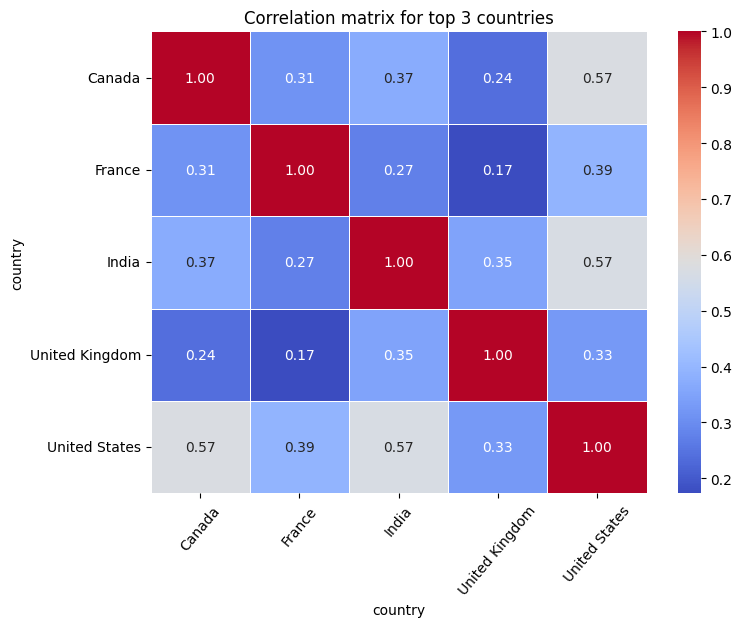

In [ ]:
corr_matrix_ = sales_by_5country.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix for top 3 countries")
plt.xticks(rotation=50)
plt.show()

Звʼязок між продажами у різних країнах є вбільшості дуже слабкий, але все ж позитивний. Кореляція є але точки на графіку розсіювання будуть доволі розкидані без чіткої лінійної залежності. Оскільки майже для всіх коефіцієнтів кореляцій є p-value < 0.05, взаємозв'язок між продажами у різних країнах є статистично значущим, тобто існує мала ймовірність того, що такий рівень кореляції отриманий випадково.

###Кореляція продажів за різними категоріями товарів:

In [ ]:
sales_by_5category = pd.pivot_table(df[df["category"].isin(["Sofas & armchairs", "Chairs", "Beds",
                                                            "Bookcases & shelving units", "Cabinets & cupboards"])],
                                     values="price", index="date", columns="category", aggfunc="sum")
categories = sales_by_5category.columns

corr_matrix = pd.DataFrame(index=categories, columns=categories)
p_value_matrix = pd.DataFrame(index=categories, columns=categories)

for i in categories:
    for j in categories:
        if i != j:
            corr, p_value = stats.pearsonr(sales_by_5category[i].dropna(), sales_by_5category[j].dropna())
            corr_matrix.loc[i, j] = corr
            p_value_matrix.loc[i, j] = p_value
        else:
            corr_matrix.loc[i, j] = 1
            p_value_matrix.loc[i, j] = np.nan

print("Correlation matrix for top 5 product categories:")
print(corr_matrix)

print("\nP-value matrix for top 5 product categories:")
print(p_value_matrix)

Correlation matrix for top 5 product categories:
category                        Beds Bookcases & shelving units  \
category                                                          
Beds                               1                   0.592913   
Bookcases & shelving units  0.592913                          1   
Cabinets & cupboards        0.514609                   0.539428   
Chairs                        0.5545                    0.63709   
Sofas & armchairs           0.535378                   0.666194   

category                   Cabinets & cupboards    Chairs Sofas & armchairs  
category                                                                     
Beds                                   0.514609    0.5545          0.535378  
Bookcases & shelving units             0.539428   0.63709          0.666194  
Cabinets & cupboards                          1   0.57287          0.657563  
Chairs                                  0.57287         1          0.578248  
Sofas & armch

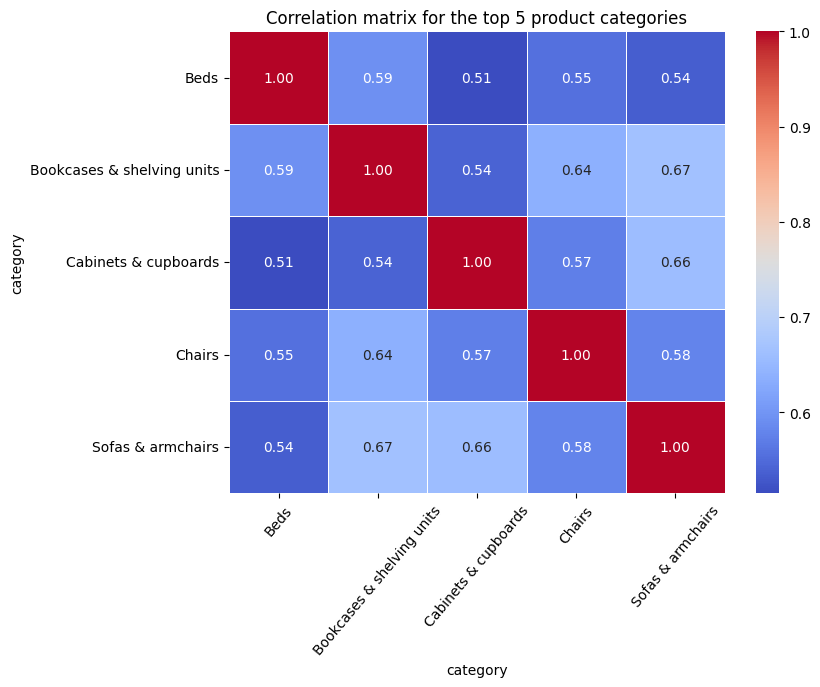

In [ ]:
corr_matrix = sales_by_5category.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=50)
plt.title("Correlation matrix for the top 5 product categories")
plt.show()

Звʼязок між продажами за різними категоріями товарів є помітний, але не надто сильний лінійний зв'язок. Кореляція є але на графіку розсіювання буде помітний загальний напрямок (вгору), але точки все ще можуть бути досить розкидані. Оскільки для всіх коефіцієнтів кореляцій є p-value < 0.05, взаємозв'язок між продажами за різними категоріями товарів є статистично значущим.

###Кореляція продажів за різними каналами трафіку:

In [ ]:
sales_by_channel = pd.pivot_table(df, values="price", index="date", columns="channel", aggfunc="sum")
channels = sales_by_channel.columns

corr_matrix = pd.DataFrame(index=channels, columns=channels)
p_value_matrix = pd.DataFrame(index=channels, columns=channels)

for i in channels:
    for j in channels:
        if i != j:
            corr, p_value = stats.pearsonr(sales_by_channel[i].dropna(), sales_by_channel[j].dropna())
            corr_matrix.loc[i, j] = corr
            p_value_matrix.loc[i, j] = p_value
        else:
            corr_matrix.loc[i, j] = 1
            p_value_matrix.loc[i, j] = np.nan

print("Correlation matrix for traffic channels:")
print(corr_matrix)

print("\nP-value matrix for traffic channels:")
print(p_value_matrix)

Correlation matrix for traffic channels:
channel           Direct Organic Search Paid Search Social Search Undefined
channel                                                                    
Direct                 1       0.759938    0.724343      0.461895  0.424039
Organic Search  0.759938              1    0.808234      0.434424  0.435418
Paid Search     0.724343       0.808234           1      0.452287  0.430021
Social Search   0.461895       0.434424    0.452287             1  0.359342
Undefined       0.424039       0.435418    0.430021      0.359342         1

P-value matrix for traffic channels:
channel           Direct Organic Search Paid Search Social Search Undefined
channel                                                                    
Direct               NaN            0.0         0.0      0.000006  0.000038
Organic Search       0.0            NaN         0.0      0.000023  0.000022
Paid Search          0.0            0.0         NaN       0.00001  0.000029
Social Se

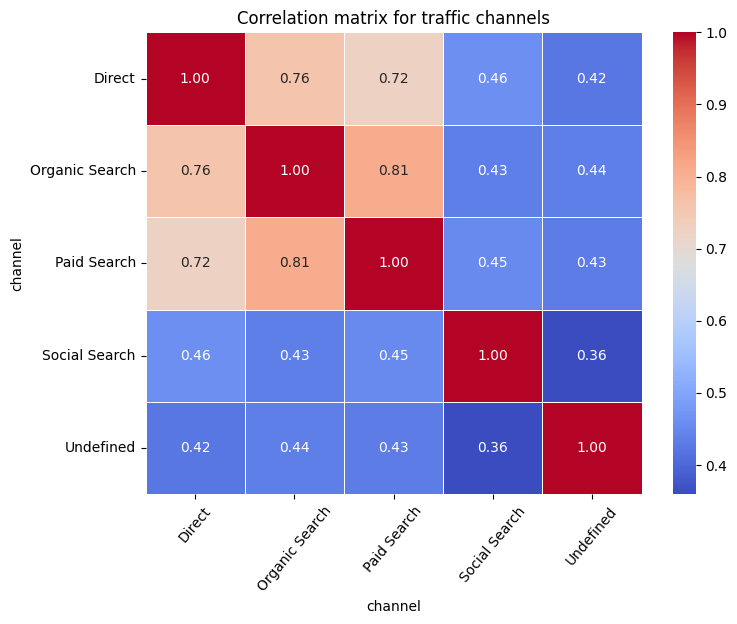

In [ ]:
corr_matrix = sales_by_channel.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=50)
plt.title("Correlation matrix for traffic channels")
plt.show()

Звʼязок між продажами на таких каналів трафіку як Direct, Organic Search, Paid Search є досить сильний позитивний. Звʼязок між продажами на інших каналах трафіку є помітний, але не надто сильний лінійний зв'язок. Кореляція є але на графіку розсіювання буде помітний загальний напрямок (вгору), але точки все ще можуть бути досить розкидані. Оскільки для всіх коефіцієнтів кореляцій є p-value < 0.05, взаємозв'язок між продажами за різними каналами трафіку є статистично значущим.

###Кореляція продажів за різними типами девайсів:

In [ ]:
sales_by_device = pd.pivot_table(df, values="price", index="date", columns="device", aggfunc="sum")
devices = sales_by_device.columns

corr_matrix = pd.DataFrame(index=devices, columns=devices)
p_value_matrix = pd.DataFrame(index=devices, columns=devices)

for i in devices:
    for j in devices:
        if i != j:
            corr, p_value = stats.pearsonr(sales_by_device[i].dropna(), sales_by_device[j].dropna())
            corr_matrix.loc[i, j] = corr
            p_value_matrix.loc[i, j] = p_value
        else:
            corr_matrix.loc[i, j] = 1
            p_value_matrix.loc[i, j] = np.nan

print("Correlation matrix for devices:")
print(corr_matrix)

print("\nP-value matrix for devices:")
print(p_value_matrix)

Correlation matrix for devices:
device    desktop    mobile    tablet
device                               
desktop         1   0.80572  0.538453
mobile    0.80572         1  0.495752
tablet   0.538453  0.495752         1

P-value matrix for devices:
device  desktop    mobile    tablet
device                             
desktop     NaN       0.0       0.0
mobile      0.0       NaN  0.000001
tablet      0.0  0.000001       NaN


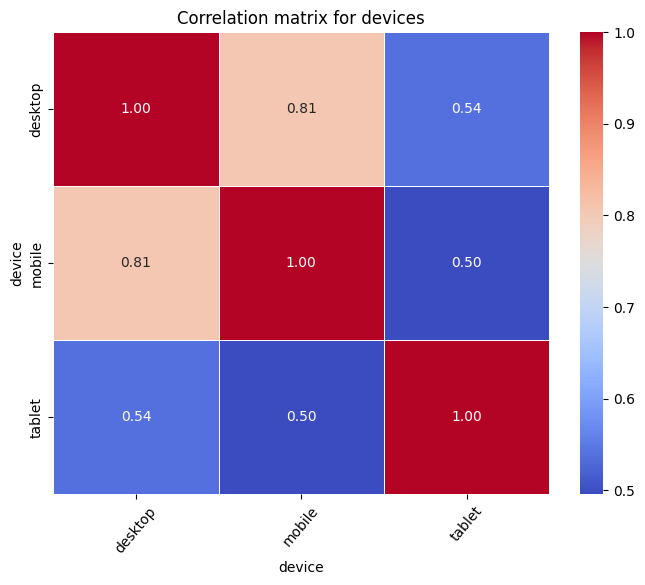

In [ ]:
corr_matrix = sales_by_device.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=50)
plt.title("Correlation matrix for devices")
plt.show()

Звʼязок між продажами на desktop і mobile є досить сильний позитивний. Звʼязок між продажами на інших типах девайсів є помітний, але не надто сильний лінійний зв'язок. Кореляція є але на графіку розсіювання буде помітний загальний напрямок (вгору), але точки все ще можуть бути досить розкидані. Оскільки для всіх коефіцієнтів кореляцій є p-value < 0.05, взаємозв'язок між продажами на різних типах девайсів є статистично значущим, тобто існує мала ймовірність того, що такий рівень кореляції отриманий випадково.

###Аналіз продажів зареєстрованих та незареєстрованих користувачів:

Покупки зареєстрованих користувачів:

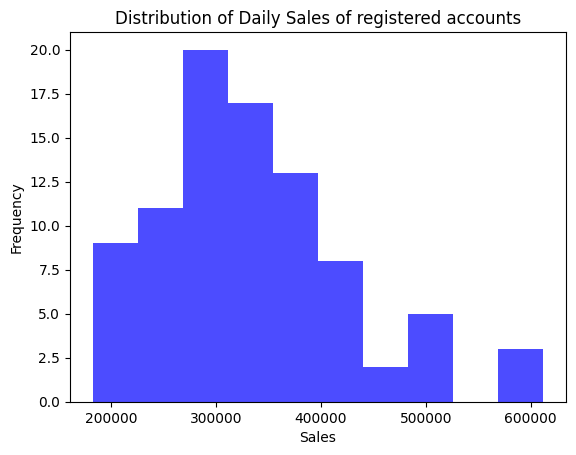

In [ ]:
sales_registered_account = pd.pivot_table(df[df["id_account"].isna()], values="price", index="date",
                                          aggfunc=["sum"]).reset_index()
plt.hist(sales_registered_account["sum"], bins=10, color="blue", alpha=0.7)
plt.title("Distribution of Daily Sales of registered accounts")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

Перевірка розподілу даних:

In [ ]:
from scipy.stats import normaltest, shapiro

_, p_value_normaltest = normaltest(sales_registered_account["sum"])
print(f"p_value for registered accounts: {p_value_normaltest}")

p_value for registered accounts: [0.00556619]


Оскільки p_value < 0,05 дані не є нормально розподілені.

Покупки не зареєстрованих користувачів:

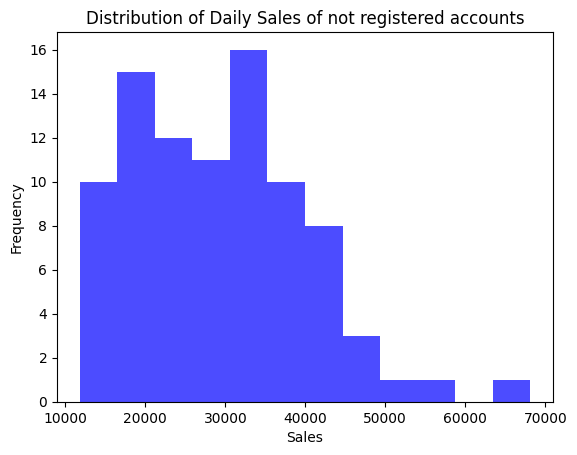

In [ ]:
sales_not_registered_accounts = pd.pivot_table(df[~df["id_account"].isna()], values="price", index="date",
                                          aggfunc=["sum"]).reset_index()
plt.hist(sales_not_registered_accounts["sum"], bins=12, color="blue", alpha=0.7)
plt.title("Distribution of Daily Sales of not registered accounts")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

Перевірка розподілу даних:

In [ ]:
_, p_value = normaltest(sales_not_registered_accounts["sum"])
print(f"p_value for not registered accounts: {p_value}")

p_value for not registered accounts: [0.01092912]


Дані не є нормально розподілені.

Оскільки дві групи даних не є нормально розподіленими скористаємося тестом Манна-Уїтні (Mann-Whitney test)  для порівняння двох вибірок:

In [ ]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(sales_registered_account["sum"], sales_not_registered_accounts["sum"])
print(f"U-statistic: {u_stat}, p-value: {p_value}")

U-statistic: [7744.], p-value: [2.2159277e-30]


Отримали p-value = 2.2159277e-30, що менше 0.05, а це означає, що зареєстровані користувачі та незареєстровані користувачі мають статистично значущу різницю в продажах.

###Аналіз кількості сесій за різними типами девайсів:

In [ ]:
number_of_sessions_device = pd.pivot_table(df, values="session_id", index="date", columns="device", aggfunc="count").reset_index()
number_of_sessions_device

device,date,desktop,mobile,tablet
0,2020-11-01,162,118,1
1,2020-11-02,215,144,9
2,2020-11-03,355,196,10
3,2020-11-04,224,136,10
4,2020-11-05,246,133,9
...,...,...,...,...
83,2021-01-23,180,131,2
84,2021-01-24,184,106,6
85,2021-01-25,220,138,12
86,2021-01-26,237,146,2


Перевірка на розподіл даних:

In [ ]:
_, p_value = normaltest(number_of_sessions_device["desktop"])
print(f"p_value: {p_value}")

p_value: 0.0037402099182746273


In [ ]:
_, p_value = normaltest(number_of_sessions_device["mobile"])
print(f"p_value: {p_value}")

p_value: 0.11756070136254969


In [ ]:
_, p_value = normaltest(number_of_sessions_device["tablet"])
print(f"p_value: {p_value}")

p_value: 0.0014747732090457724


Дві з троьох груб даних не є номально розполілені, використаємо тест Крустала-Уолліса для порівняння трьох вибірок даних:

In [ ]:
from scipy.stats import kruskal

_, p_value = kruskal(number_of_sessions_device["mobile"], number_of_sessions_device["tablet"], number_of_sessions_device["desktop"])

print(f"P-value: {p_value}")

P-value: 1.0450915873855254e-45


Отримали p-value < 0.05, а це означає, що кількість сесій на різних типах девайсів мають статистично значущу різницю.

###Аналіз долі сесій з органічним трафіком у Європі та Америці:

In [ ]:
grouped = df[df["continent"].isin(["Americas", "Europe"])].groupby(["continent", "channel"])["session_id"].count().unstack()
grouped["total_sessions"] = grouped.sum(axis=1)

grouped = grouped.reset_index()
grouped

channel,continent,Direct,Organic Search,Paid Search,Social Search,Undefined,total_sessions
0,Americas,4309,6536,5020,1519,1169,18553
1,Europe,1489,2238,1670,519,345,6261


Скористаємося тестом пропорції:

In [ ]:
import statsmodels.api as sm

sessions_a = grouped.loc[grouped["continent"] == "Americas", "Organic Search"].iloc[0]
sessions_b = grouped.loc[grouped["continent"] == "Europe", "Organic Search"].iloc[0]
all_sessions_a = grouped.loc[grouped["continent"] == "Americas", "total_sessions"].iloc[0]
all_sessions_b = grouped.loc[grouped["continent"] == "Europe", "total_sessions"].iloc[0]

_, p_value = sm.stats.proportions_ztest([sessions_a, sessions_b], [all_sessions_a, all_sessions_b])

print(f"P-value: {p_value}")

P-value: 0.45998850476985065


Оскільки p-value = 0.45998 більше за 0.05, то різниця не є статистично значущою.

###Висновки:

1. Найбільші продажі та доходи компанія отримує з Америки, Азії та Європи, а серед країн – США, Індія, Канада, Велика Британія та Франція.
Америка є ключовим ринком, що приносить найбільший дохід.
Кореляція між продажами на різних континентах є позитивною, але не ідеальною, що свідчить про певні відмінності в споживчих тенденціях.
Продажі в різних країнах мають слабкий зв’язок, що вказує на різні фактори впливу (економічні, культурні, маркетингові).
Потрібно оптимізувати маркетингові кампанії для ключових ринків (США, Індія, Канада, Велика Британія, Франція). Вивчити фактори, що впливають на слабку кореляцію продажів між країнами (споживчі звички, конкурентне середовище, локальні маркетингові стратегії). Розглянути локалізовані рекламні кампанії та спеціальні пропозиції для кожного з основних ринків.

2. Найбільший дохід і кількість продажів приносять:
Sofas & armchairs (лідер продажів на всіх континентах і в США).
Зв’язок між продажами різних категорій товарів є помітним, але не надто сильним, що свідчить про певні відмінності в попиті.
Потрібно посилити рекламні кампанії для Sofas & armchairs як категорії, що приносить найбільший дохід.
Вивчити, які фактори впливають на попит у різних країнах і континентах, щоб адаптувати асортимент та акції. Оптимізувати складські запаси для найпопулярніших товарів.

3. Найбільше доходу приносить трафік із:
Organic Search, Paid Search, Direct (мають сильний позитивний зв’язок із продажами).
Найбільше сесій здійснено через Organic Search на desktop.
Найбільше доходу приносять замовлення з desktop, а найменше – з tablet.
Кореляція між продажами на desktop і mobile є досить сильною, що вказує на важливість цих платформ.
Необхідно продовжити оптимізацію сайту для desktop (основне джерело доходу).
Покращити мобільну версію сайту, оскільки mobile також має високі продажі, але його можна посилити.
Розробити стратегію для збільшення конверсій із tablet, оскільки цей пристрій має найменший внесок у дохід.

4. Є чітка тижнева сезонність, коли активність клієнтів зростає в певні дні.
Помітне зростання продажів у грудні 2020 та січні 2021 року (ймовірно, через акції та розпродажі).
Сезонні патерни однакові для всіх континентів і категорій товарів.
Необхідно використати тижневу сезонність – налаштувати рекламні кампанії та знижки у дні пікової активності.
Планувати великі розпродажі на початок грудня та січня, оскільки ці періоди приносять значний дохід.
Використати ці патерни для оптимізації запасів товарів та логістики.

5. Коефіцієнт кореляції між продажами та кількістю сесій = 0.964, що свідчить про дуже сильний прямий зв’язок.
Збільшення трафіку безпосередньо впливатиме на продажі, тому слід інвестувати контент-маркетинг, рекламу та email-кампанії.

6. P-value < 0.05 вказує на статистично значущу різницю між зареєстрованими та незареєстрованими користувачами щодо обсягу покупок.
Тому потрібно стимулювати реєстрацію (бонуси, ексклюзивні знижки для зареєстрованих).
Використати email-маркетинг для повторних продажів серед зареєстрованих користувачів.

[Dashboard](https://public.tableau.com/app/profile/aniuta.muliarchuk/viz/Onlinestoresalesanalytics/Onlinestoresalesanalytics)